In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob #May be used instead of OS
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
import pydicom
import time
import matplotlib.image as mpimg
from PIL import Image

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
startall=time.time() #To find total time needed for this script

In [3]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
61074,00015068_005.png,No Finding,5,15068,66,M,PA,2992,2991,0.143,0.143,NaN
16782,00004512_000.png,Atelectasis,0,4512,12,M,AP,2500,2048,0.171,0.171,NaN
60369,00014906_006.png,No Finding,6,14906,66,M,AP,2500,2048,0.168,0.168,NaN


In [4]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
### Load image paths to be used later
data_sample_paths={os.path.basename(x):x for x in glob(os.path.join('/data','images*','*','*.png'))}
sample_df['path']=sample_df['Image Index'].map(data_sample_paths.get)
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
2500,00012594_001.png,Nodule,1,12594,053Y,M,PA,2992,2991,0.143,0.143,/data/images_006/images/00012594_001.png
744,00003896_005.png,Nodule,5,3896,074Y,F,PA,2392,2728,0.139,0.139,/data/images_002/images/00003896_005.png
2879,00014203_045.png,No Finding,45,14203,031Y,M,AP,2500,2048,0.168,0.168,/data/images_007/images/00014203_045.png


In [5]:
#Drop columns with NA
all_xray_df.drop(columns=['Unnamed: 11'], inplace=True)

In [6]:
#Drop rows for which patient age>100
del_age=all_xray_df[all_xray_df['Patient Age'] > 100].index.tolist()
all_xray_df.drop(index=del_age,  inplace=True)
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143
...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168


Ages of participants are [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95] 

Maximum and minimum ages of participants are: 95, 1 respectively
Patient Genders are ['F' 'M'] 

Percentage of each value is: 

M    0.564904
F    0.435096
Name: Patient Gender, dtype: float64
View Positions ['AP' 'PA'] 

Percentage of each value is: 

PA    0.600326
AP    0.399674
Name: View Position, dtype: float64
Follow up [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  

Text(0, 0.5, 'Values')

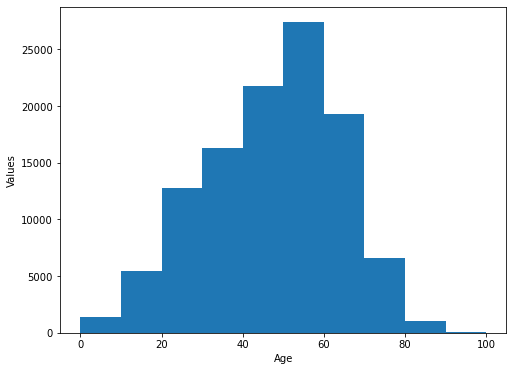

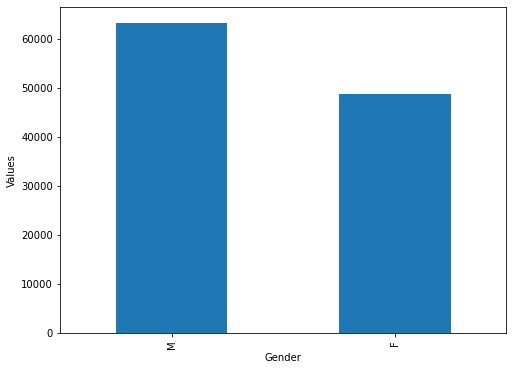

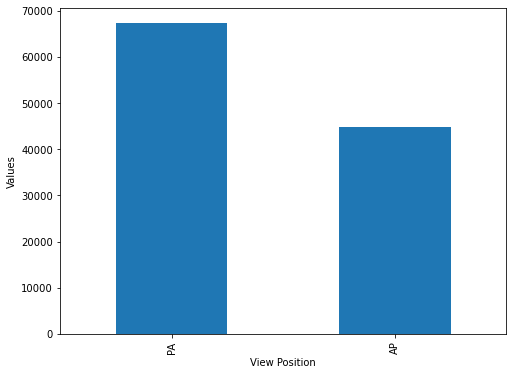

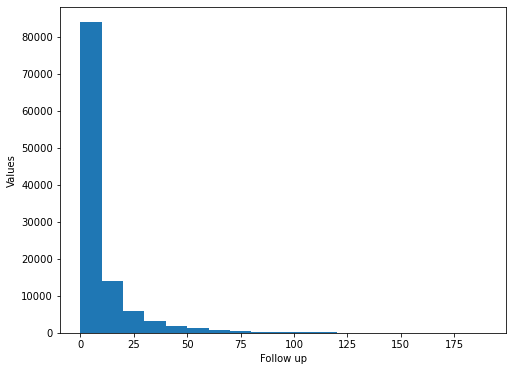

In [7]:
## EDA
# Todo 

#Histogram of age distribution
print("Ages of participants are {} \n".format(np.unique(all_xray_df["Patient Age"])))
plt.figure(figsize=(8,6))
plt.hist(all_xray_df["Patient Age"],range=[0, 100], bins=10)
plt.xlabel('Age')
plt.ylabel('Values')
print("Maximum and minimum ages of participants are: {}, {} respectively".format(np.max(all_xray_df["Patient Age"]), 
                                                                                 np.min(all_xray_df["Patient Age"])))

#Bar plot of gender distribution
print("Patient Genders are {} \n".format(np.unique(all_xray_df["Patient Gender"])))
plt.figure(figsize=(8,6))
all_xray_df['Patient Gender'].value_counts().plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Values')
print("Percentage of each value is: \n")
print(all_xray_df['Patient Gender'].value_counts(normalize=True))

#Bar plot of viewing position
print("View Positions {} \n".format(np.unique(all_xray_df["View Position"])))
plt.figure(figsize=(8,6))
all_xray_df['View Position'].value_counts().plot(kind='bar')
plt.xlabel('View Position')
plt.ylabel('Values')
print("Percentage of each value is: \n")
print(all_xray_df['View Position'].value_counts(normalize=True))

#Bar plot of follow up
print("Follow up {} \n".format(np.unique(all_xray_df["Follow-up #"])))
plt.figure(figsize=(8,6))
plt.hist(all_xray_df["Follow-up #"],range=[0, 190], bins=19)
plt.xlabel('Follow up')
plt.ylabel('Values')

In [8]:
#Find unique diseases in the dataset

#Using chain like in lesson exercises
# beg=time.time()
# from itertools import chain
# all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
# all_labels=all_labels.tolist()
# end=time.time()
# print(end-beg)

#Without any additional libraries - Less time to do it
beg=time.time()
labels=all_xray_df['Finding Labels'].tolist()
labelsnew=[]
for i in labels:
    elem=i.split('|')
    for j in elem:
        labelsnew.append(j)
labelsnew=np.unique(labelsnew).tolist()
end=time.time()
print(end-beg)
labelsnew

0.12734246253967285


['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [9]:
#Create additional columns in dataframe with the label of each disease
for i in labelsnew:
    all_xray_df[i]=0
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,0


In [10]:
#Based on "Finding Labels" We add 1s to the corresponding columns with diseases that we created
all_xray_df.index = range(len(all_xray_df)) #Change indexing - Otherwise problem with the loop below
beg=time.time()
for ind,val in enumerate(all_xray_df['Finding Labels']):
    for j in labelsnew:
        if j in val:
            all_xray_df.at[ind,j]=1
end=time.time()
print("Time to run {}".format(end-beg))
all_xray_df

Time to run 1.3656425476074219


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112099,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0,0,0,0,1,0,0,0,1,0
112100,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0,0,0,0,0,1,0,0,0,0
112101,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0,0,0,0,0,1,0,0,0,0
112102,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0,0,0,0,0,1,0,0,0,0


In [11]:
#Print top 20 labels that exist in data (in percentages)
(all_xray_df[labelsnew].sum()/len(all_xray_df)).nlargest(20)

No Finding            0.538366
Infiltration          0.177433
Effusion              0.118783
Atelectasis           0.103101
Nodule                0.056474
Mass                  0.051550
Pneumothorax          0.047286
Consolidation         0.041631
Pleural_Thickening    0.030186
Cardiomegaly          0.024763
Emphysema             0.022443
Edema                 0.020535
Fibrosis              0.015040
Pneumonia             0.012756
Hernia                0.002025
dtype: float64

Most of the data have no findings (~54%). Diseases are the rest of the data (~46%). 

In [12]:
# onlydis=labelsnew
# onlydis.remove("No Finding")
# onlydis
onedis=np.sum(all_xray_df["Finding Labels"]!="No Finding")
print("Number of images with at least one disease: {}".format(onedis))
print("Number of images with no disease: {}".format(len(all_xray_df)-onedis))

Number of images with at least one disease: 51751
Number of images with no disease: 60353


In [13]:
#Finding the total pneumonia cases
pneum=np.sum(all_xray_df["Pneumonia"])
print("We have in total {} pneumonia cases and {} non-pneumonia cases (other diseases or no findings)"
      .format(pneum,len(all_xray_df)-pneum))
#It should be noted that some of these cases refer to the same patient ID.
print("Percentage of patients with pneumonia over the total population is {}%".format(100*pneum/len(all_xray_df)))
onlydis=len(all_xray_df)-np.sum(all_xray_df["Finding Labels"]=="No Finding")
print("Percentage of patients with pneumonia over the individuals with at least one disease is {}%".format(100*pneum/onlydis))

We have in total 1430 pneumonia cases and 110674 non-pneumonia cases (other diseases or no findings)
Percentage of patients with pneumonia over the total population is 1.2756012274316706%
Percentage of patients with pneumonia over the individuals with at least one disease is 2.763231628374331%


In [14]:
pneumoage = all_xray_df[(all_xray_df['Pneumonia'] == 1) & (all_xray_df['Patient Age'] < 100)]['Patient Age']
print("Minimum age of patient with pneumonia is {}".format(np.min(pneumoage)))
print("Maximum age of patient with pneumonia is {}".format(np.max(pneumoage)))

Minimum age of patient with pneumonia is 2
Maximum age of patient with pneumonia is 90


In [15]:
pneumomale=all_xray_df[(all_xray_df['Pneumonia'] == 1) & (all_xray_df['Patient Age'] < 100) & (all_xray_df['Patient Gender'] == 'M')]['Patient Age']
pneumofem=all_xray_df[(all_xray_df['Pneumonia'] == 1) & (all_xray_df['Patient Age'] < 100) & (all_xray_df['Patient Gender'] == 'F')]['Patient Age']
print("Minimum age of males with pneumonia is {}".format(np.min(pneumomale)))
print("Maximum age of males with pneumonia is {}".format(np.max(pneumomale)))
print("Minimum age of females with pneumonia is {}".format(np.min(pneumofem)))
print("Maximum age of females with pneumonia is {}".format(np.max(pneumofem)))

Minimum age of males with pneumonia is 2
Maximum age of males with pneumonia is 87
Minimum age of females with pneumonia is 3
Maximum age of females with pneumonia is 90


Ages of participants are [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 87 90] 

Maximum and minimum ages of participants are: 90, 2 respectively
Patient Genders are ['F' 'M'] 

Percentage of each value is: 

M    0.585315
F    0.414685
Name: Patient Gender, dtype: float64
View Positions ['AP' 'PA'] 

Percentage of each value is: 

AP    0.559441
PA    0.440559
Name: View Position, dtype: float64


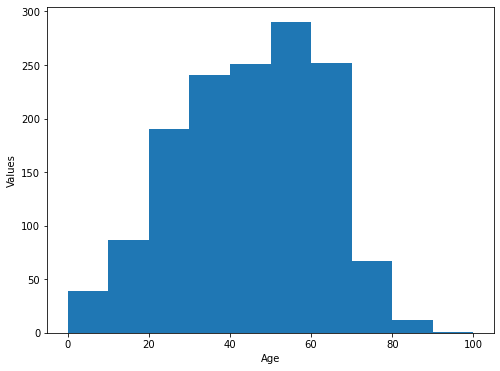

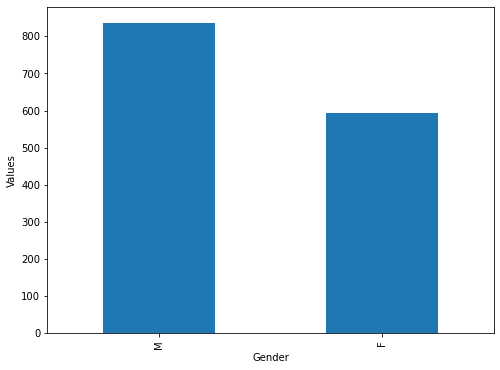

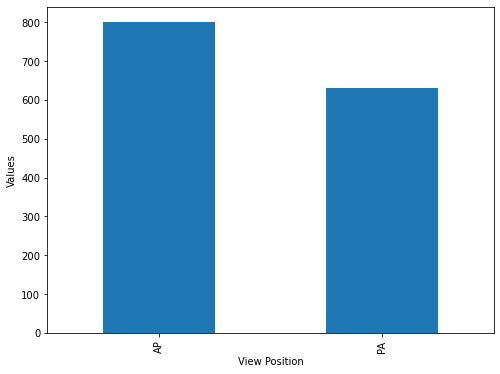

In [16]:
pneumonia_only=all_xray_df[all_xray_df['Pneumonia'] == 1]

#Histogram of age distribution for patients with pneumonia
print("Ages of participants are {} \n".format(np.unique(pneumonia_only["Patient Age"])))
plt.figure(figsize=(8,6))
plt.hist(pneumonia_only["Patient Age"],range=[0, 100], bins=10)
plt.xlabel('Age')
plt.ylabel('Values')
print("Maximum and minimum ages of participants are: {}, {} respectively".format(np.max(pneumonia_only["Patient Age"]), 
                                                                                 np.min(pneumonia_only["Patient Age"])))

#Bar plot of gender distribution for patients with pneumonia
print("Patient Genders are {} \n".format(np.unique(pneumonia_only["Patient Gender"])))
plt.figure(figsize=(8,6))
pneumonia_only['Patient Gender'].value_counts().plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Values')
print("Percentage of each value is: \n")
print(pneumonia_only['Patient Gender'].value_counts(normalize=True))

#Bar plot of viewing position for patients with pneumonia
print("View Positions {} \n".format(np.unique(pneumonia_only["View Position"])))
plt.figure(figsize=(8,6))
pneumonia_only['View Position'].value_counts().plot(kind='bar')
plt.xlabel('View Position')
plt.ylabel('Values')
print("Percentage of each value is: \n")
print(pneumonia_only['View Position'].value_counts(normalize=True))

The distributions of age and gender of patients with pneumonia are very similar with those of the total population. For view position, in the total population the percentage is 60% PA and 40% AP while for pneumonia patients this percentage is 56% AP and 44% PA. The reason for that prevelance is that pneumonia can be more easily detected in AP views. If this is not the case, then the detection of pneumonia will be much more difficult. If we want to keep the same distribution we would have to reject a few examples from both the training and the validation sets.

In [17]:
# np.sum(all_xray_df["Mass"] if all_xray_df["Pneumonia"]==1)
comorb=[]
for i in labelsnew:
    numcas=np.sum(all_xray_df[all_xray_df["Pneumonia"]==1][i])
    print("There are {} cases of {} that are comorbid with pneumonia".format(numcas,i))#.value_counts().plot(kind='bar')
    comorb.append([i, numcas])
comorb
#Again it should be noted that we may have duplicate results since a patient may has more than 3 diseases
#This is an extra analysis that is not needed

There are 262 cases of Atelectasis that are comorbid with pneumonia
There are 41 cases of Cardiomegaly that are comorbid with pneumonia
There are 123 cases of Consolidation that are comorbid with pneumonia
There are 340 cases of Edema that are comorbid with pneumonia
There are 268 cases of Effusion that are comorbid with pneumonia
There are 23 cases of Emphysema that are comorbid with pneumonia
There are 11 cases of Fibrosis that are comorbid with pneumonia
There are 3 cases of Hernia that are comorbid with pneumonia
There are 605 cases of Infiltration that are comorbid with pneumonia
There are 71 cases of Mass that are comorbid with pneumonia
There are 0 cases of No Finding that are comorbid with pneumonia
There are 70 cases of Nodule that are comorbid with pneumonia
There are 48 cases of Pleural_Thickening that are comorbid with pneumonia
There are 1430 cases of Pneumonia that are comorbid with pneumonia
There are 41 cases of Pneumothorax that are comorbid with pneumonia


[['Atelectasis', 262],
 ['Cardiomegaly', 41],
 ['Consolidation', 123],
 ['Edema', 340],
 ['Effusion', 268],
 ['Emphysema', 23],
 ['Fibrosis', 11],
 ['Hernia', 3],
 ['Infiltration', 605],
 ['Mass', 71],
 ['No Finding', 0],
 ['Nodule', 70],
 ['Pleural_Thickening', 48],
 ['Pneumonia', 1430],
 ['Pneumothorax', 41]]

In [18]:
#Split the above into to lists, one with diseases and one with number of patients with that disease
disea=[]
nocas=[]
for i in comorb:
    disea.append(i[0])
    nocas.append(i[1])
print(disea)
print(nocas)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
[262, 41, 123, 340, 268, 23, 11, 3, 605, 71, 0, 70, 48, 1430, 41]


In [19]:
print("Total cases with pneumonia and at least one more disease is {}".format(np.sum(nocas)-1430))

Total cases with pneumonia and at least one more disease is 1906


[Text(0, 0, 'Atelectasis'),
 Text(0, 0, 'Cardiomegaly'),
 Text(0, 0, 'Consolidation'),
 Text(0, 0, 'Edema'),
 Text(0, 0, 'Effusion'),
 Text(0, 0, 'Emphysema'),
 Text(0, 0, 'Fibrosis'),
 Text(0, 0, 'Hernia'),
 Text(0, 0, 'Infiltration'),
 Text(0, 0, 'Mass'),
 Text(0, 0, 'No Finding'),
 Text(0, 0, 'Nodule'),
 Text(0, 0, 'Pleural_Thickening'),
 Text(0, 0, 'Pneumonia'),
 Text(0, 0, 'Pneumothorax')]

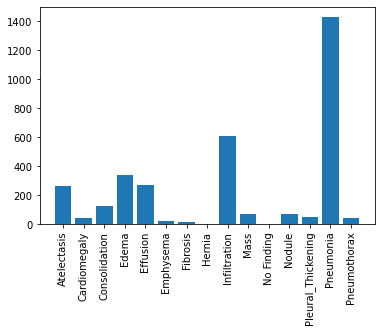

In [20]:
inds=range(len(nocas))
fig,ax = plt.subplots()
rects = ax.bar(inds, nocas)
ax.set_xticks(inds)
ax.set_xticklabels(disea, rotation='vertical')#,fontsize=3)

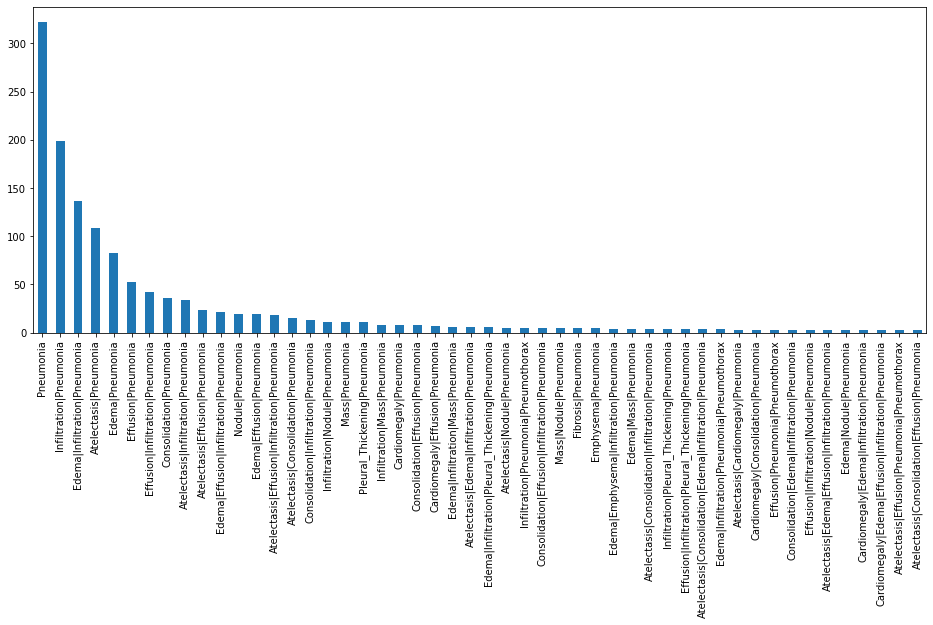

In [21]:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:50].plot(kind='bar')
#The disease that is more comorbid with pneumonia is infiltration

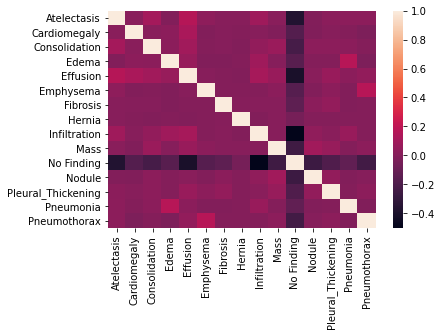

In [22]:
cor_df = all_xray_df[labelsnew]
correl = cor_df.corr() 
sns.heatmap(correl);

From the above heatmap it can be seen that the strongest correlation of pneumopnia is with edema and infiltration. This will probably make difficult for the network to distinguish between these cases and it may outputs 'pneumonia' in images with these two diseases. If we want to compare the performance of the network for these two cases we should train a new model without examples from these two diseases and compare it with the results of the networks we already have.

Based on the above, since there are only 1431 pneumonia cases, we should make sure that 80% of these end up in the training set and 20% in the validation set. This means that 1144 pneumonia images end up in training set and the rest 286 in the validation set. Moreover, since there are 110677 non pneumonia cases, 80% of those end up in the training and 20% in the validation set. That is 88542 in the training and 22135 in the validation set. Since the training set must be balanced we only keep 1144 non pneumonia cases (maybe with other diseases). Since the validation set should be representative of the distribution of diseases in the real world, and assuming that 20% of patients have pneumonia, we keep in total 286 pneumonia and 1144 non pneumonia (maybe with other diseases) cases.

For all other variables in our dataset such as age, sex, view position, the distribution of both training and validation sets should follow the same distribution as our original full dataset. For example, we should have more males than females and more PA than AP view positions in both of these sets. We assume that these distributions are preserved during the above splits.

In [23]:
beg=time.time()
pat=np.unique(all_xray_df["Patient ID"])
id=[]
nodis=[]
for i in range(len(pat)):
    dislabels=all_xray_df["Finding Labels"][all_xray_df["Patient ID"]==pat[i]]
    numdis=[]
    for j in dislabels:
        disease=j.split('|')
        for k in disease:
            numdis.append(k)
    id.append(pat[i])
    if "No Finding" in np.unique(numdis):
        nodis.append(len(np.unique(numdis))-1)
    else:
        nodis.append(len(np.unique(numdis)))

end=time.time()
print("Time to run {}".format(end-beg))
print(id)
print(nodis)
# The above shows the number of diseases for each patient ID       

Time to run 21.69640016555786
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 21

In [24]:
sample_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,0.139000,/data/images_001/images/00000013_005.png
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,0.168000,/data/images_001/images/00000013_026.png
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,0.168000,/data/images_001/images/00000017_001.png
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,0.143000,/data/images_001/images/00000030_001.png
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,0.168000,/data/images_001/images/00000032_001.png
...,...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,0.194311,/data/images_012/images/00030712_000.png
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,0.139000,/data/images_012/images/00030786_005.png
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,0.194311,/data/images_012/images/00030789_000.png
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,0.194311,/data/images_012/images/00030792_000.png


In [25]:
#Based on "Finding Labels" We add 1s to the corresponding columns with diseases that we created - same as before
for i in labelsnew:
    sample_df[i]=0
    
sample_df.index = range(len(sample_df)) #Change indexing - Otherwise problem with the loop below
beg=time.time()
for ind,val in enumerate(sample_df['Finding Labels']):
    for j in labelsnew:
        if j in val:
            sample_df.at[ind,j]=1
end=time.time()
print("Time to run {}".format(end-beg))
sample_df

Time to run 0.06672263145446777


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,...,1,0,0,1,0,0,0,1,0,1
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,...,1,0,0,0,0,0,0,0,0,0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,...,0,0,0,0,0,1,0,0,0,0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,...,0,0,0,0,0,0,0,0,0,0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,...,0,0,0,0,0,1,0,0,0,0
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,...,1,0,0,0,0,0,0,0,0,0
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,...,0,0,0,1,0,0,0,0,0,0
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,...,0,0,0,0,0,1,0,0,0,0


In [26]:
#Dataframe with all information for images with no findings
nofinds=sample_df[sample_df["Finding Labels"]=="No Finding"]
nofinds.sort_values("Patient ID")

#Dataframe with all information for images with at least one disease
finds=sample_df[sample_df["Finding Labels"]!="No Finding"]
finds.sort_values("Patient ID")
finds

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,...,1,0,0,1,0,0,0,1,0,1
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,...,1,0,0,0,0,0,0,0,0,0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,...,0,0,0,0,0,0,0,0,0,0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,...,0,0,0,0,0,0,0,0,0,0
5,00000040_003.png,Consolidation|Mass,3,40,068Y,M,PA,2500,2048,0.168000,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5595,00030636_014.png,Atelectasis|Effusion|Pneumothorax,14,30636,046Y,M,PA,2021,2021,0.194311,...,0,0,0,0,0,0,0,0,0,1
5598,00030650_002.png,Infiltration|Pneumothorax,2,30650,067Y,M,PA,2020,2021,0.194314,...,0,0,0,1,0,0,0,0,0,1
5599,00030695_002.png,Atelectasis,2,30695,052Y,F,PA,2021,2021,0.194311,...,0,0,0,0,0,0,0,0,0,0
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,...,1,0,0,0,0,0,0,0,0,0


In [27]:
nofinds

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,...,0,0,0,0,0,1,0,0,0,0
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139000,...,0,0,0,0,0,1,0,0,0,0
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139000,...,0,0,0,0,0,1,0,0,0,0
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139000,...,0,0,0,0,0,1,0,0,0,0
12,00000080_005.png,No Finding,5,80,067Y,F,PA,1884,2021,0.194311,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5597,00030639_001.png,No Finding,1,30639,061Y,M,AP,3056,2544,0.139000,...,0,0,0,0,0,1,0,0,0,0
5600,00030704_000.png,No Finding,0,30704,052Y,F,PA,2021,2021,0.194311,...,0,0,0,0,0,1,0,0,0,0
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,...,0,0,0,0,0,1,0,0,0,0
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,...,0,0,0,0,0,1,0,0,0,0


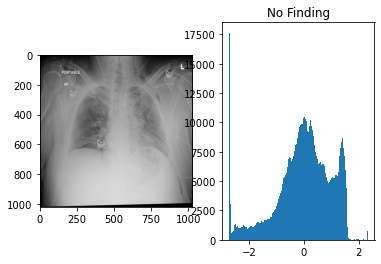

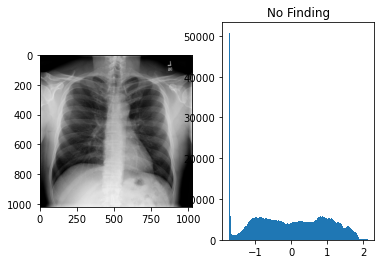

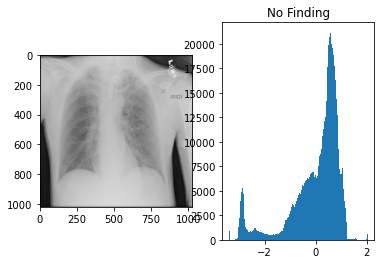

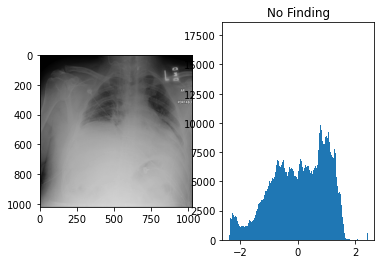

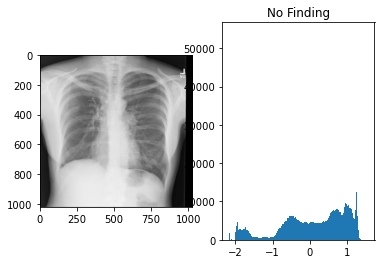

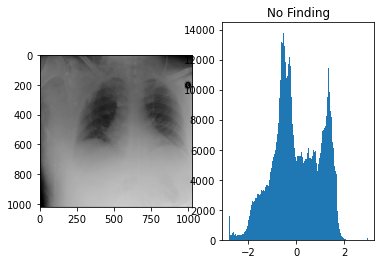

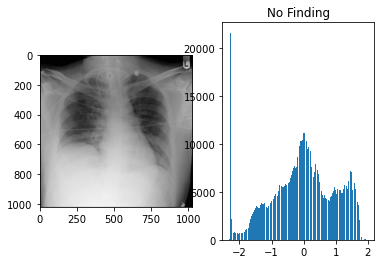

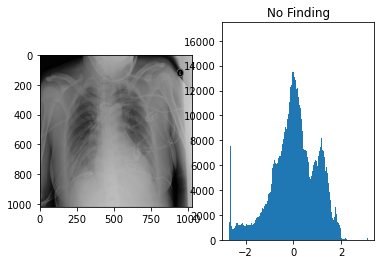

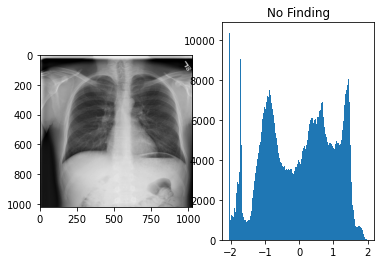

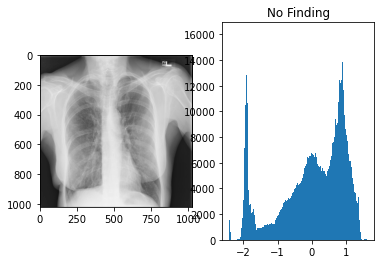

In [28]:
nofindsnew=nofinds[nofinds.duplicated(["Patient ID"])] 
# For the above we are more confident that they do not have a disease since in two different sessions no disease was found.

nofindlist=[]
for i in range(0,50,5): #just show the first few images and normalized histograms
    path=nofindsnew["path"].iloc[i]
    image = mpimg.imread(path)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image, cmap='gray')
    plt.title(nofindsnew["Finding Labels"].iloc[i])

    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    new_img = image.copy()
    new_img = (new_img - mean_intensity)/std_intensity
    ax2.hist(new_img.ravel(), bins = 256)
    plt.show()
#Plot the pictures along with the normalized histograms for the first few non-diseased individuals

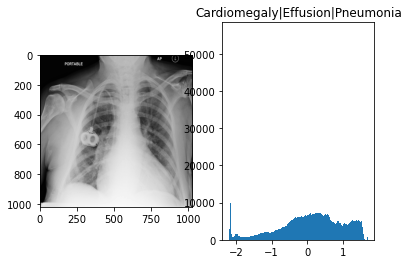

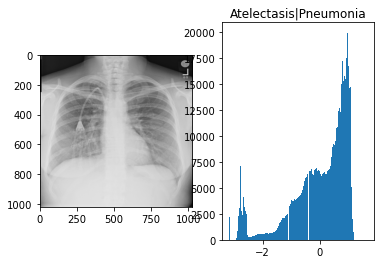

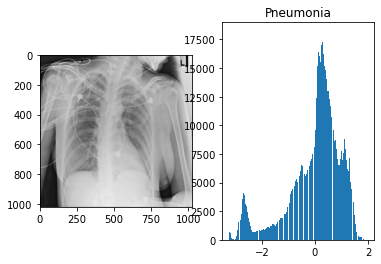

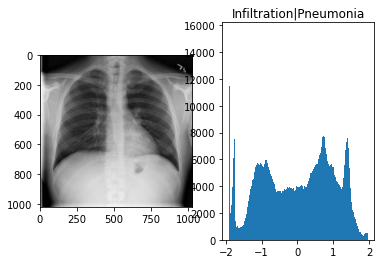

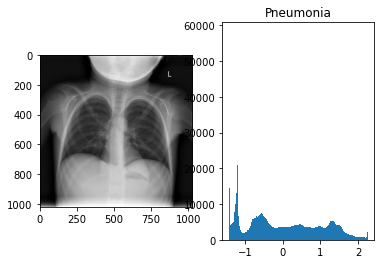

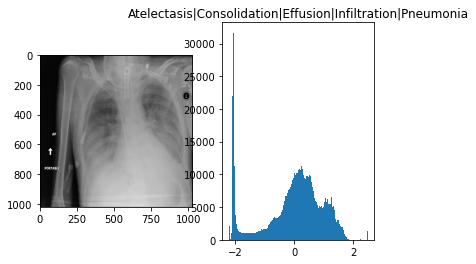

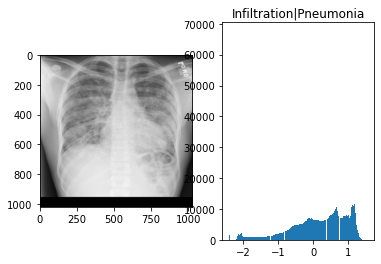

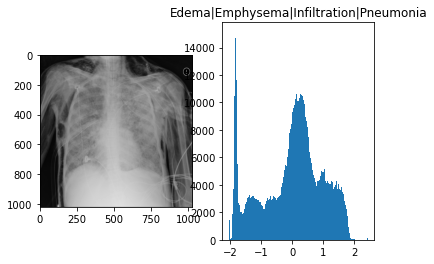

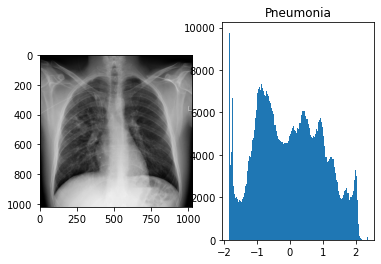

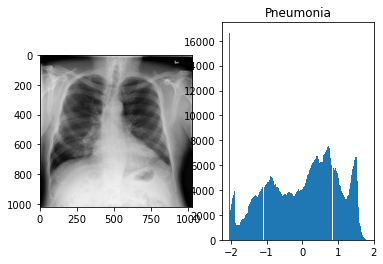

In [29]:
#Plot the pictures along with the normalized histograms for the first few individuals with pneumonia
pneumo = finds[finds['Pneumonia'] == 1]
for i in range(0,50,5):
    path=pneumo["path"].iloc[i]
    image = mpimg.imread(path)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image, cmap='gray')
    plt.title(pneumo["Finding Labels"].iloc[i])
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    new_img = image.copy()
    new_img = (new_img - mean_intensity)/std_intensity
    ax2.hist(new_img.ravel(), bins = 256)
    plt.show()

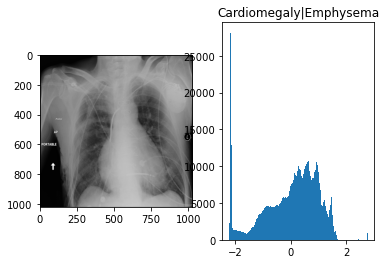

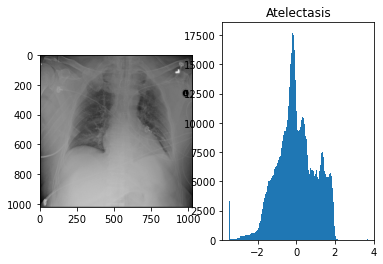

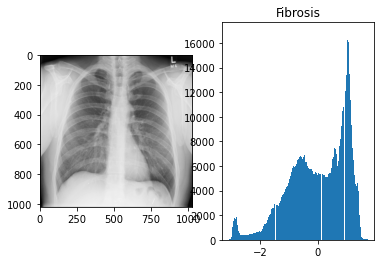

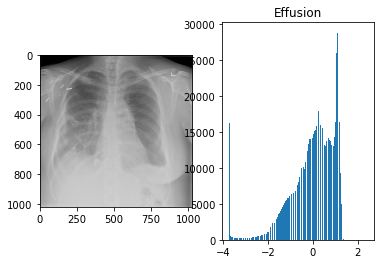

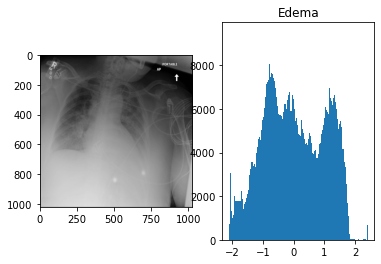

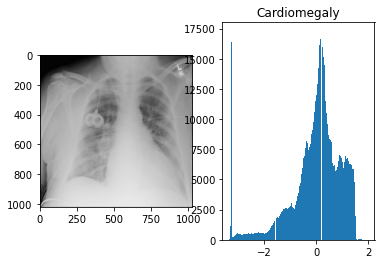

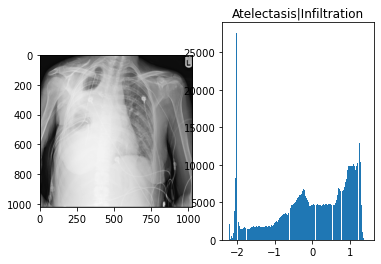

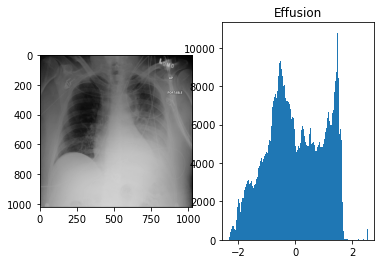

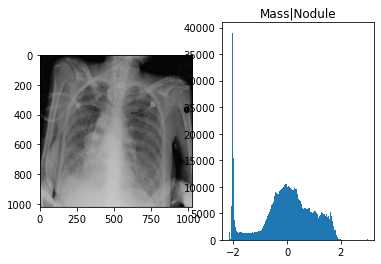

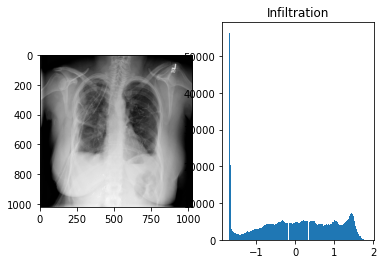

In [30]:
findsnew=finds[finds.duplicated(["Patient ID"])] 
# For these we are more confident that they do have a disease since at least one disease was found in two different sessions.

findlist=[]
for i in range(0,50,5):
    path=findsnew["path"].iloc[i]
    image = mpimg.imread(path)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image, cmap='gray')
    plt.title(findsnew["Finding Labels"].iloc[i])
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    new_img = image.copy()
    new_img = (new_img - mean_intensity)/std_intensity
    ax2.hist(new_img.ravel(), bins = 256)
    plt.show()
#Plot the pictures along with the normalized histograms for the first few diseased individuals

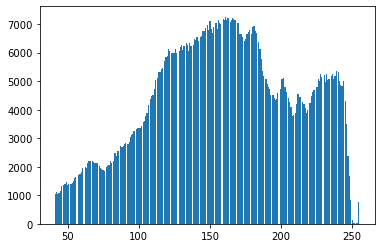

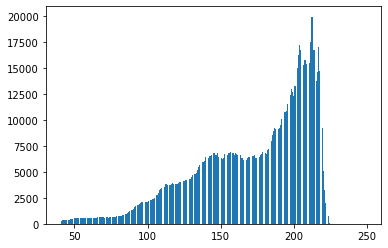

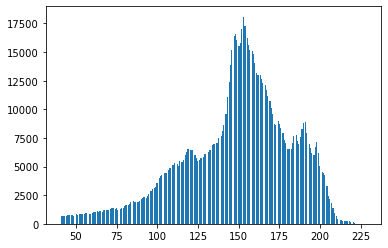

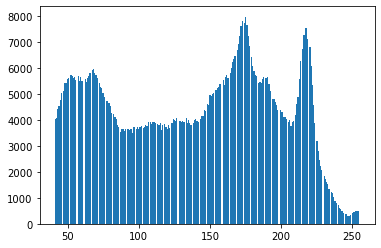

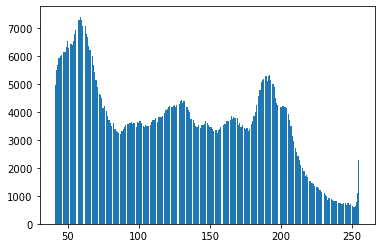

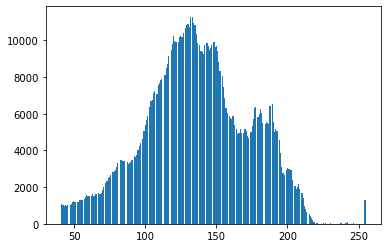

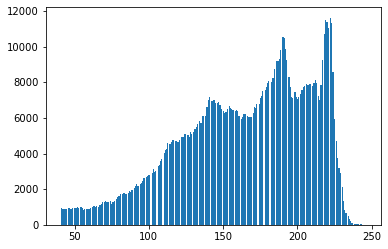

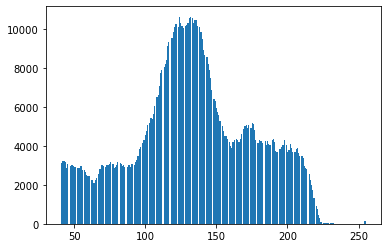

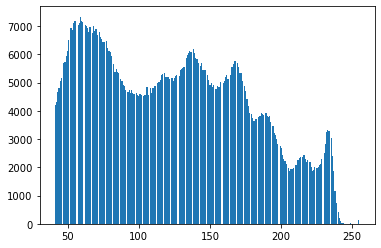

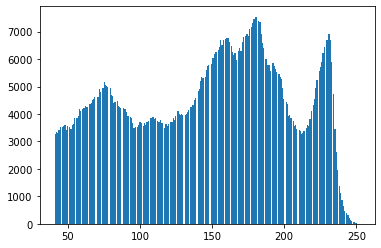

In [31]:
#Here we need extra packages to have true intensity values when we load images and not normalized from the beginning
from skimage.io import imread, imshow
from skimage import io

pneumo = finds[finds['Pneumonia'] == 1]
for i in range(0,50,5):
    path=pneumo["path"].iloc[i]    
    image = io.imread(path)
    image = image[image > 40] #Remove background and boundary pixel values
    fig, (ax1) = plt.subplots(1, 1)
    ax1.hist(image.ravel(), bins = 256)
    plt.show()
#Plot the pictures along with the unnormalized histograms for the first few individuals with pneumonia (excluding black pixels)

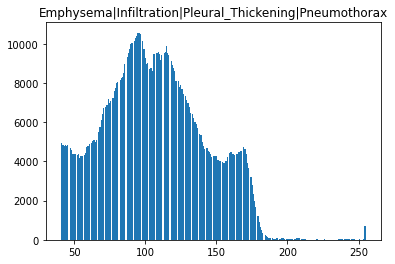

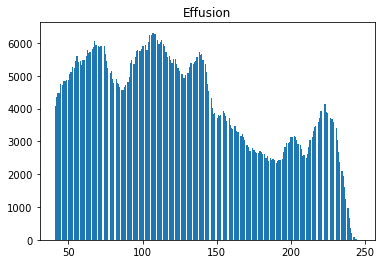

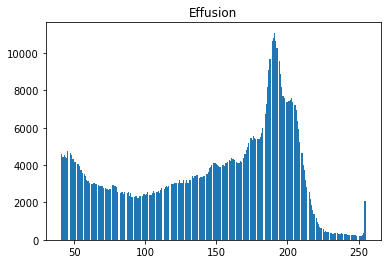

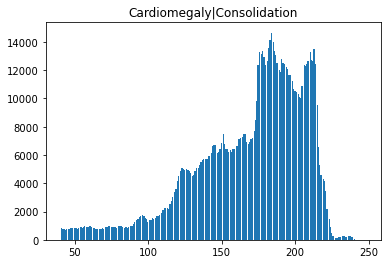

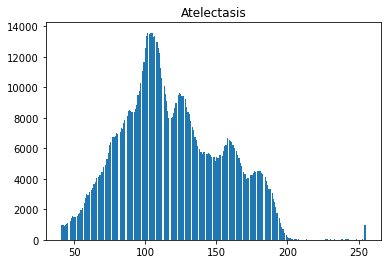

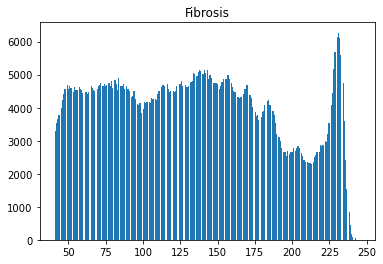

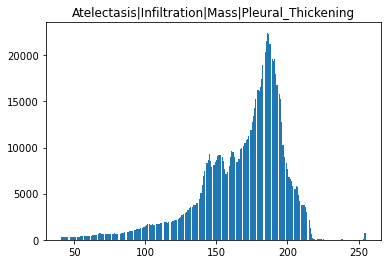

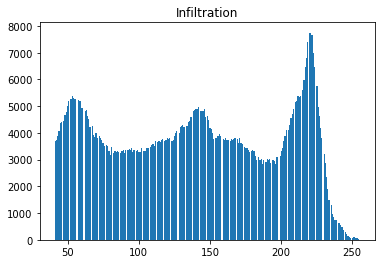

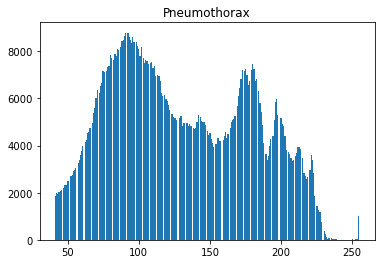

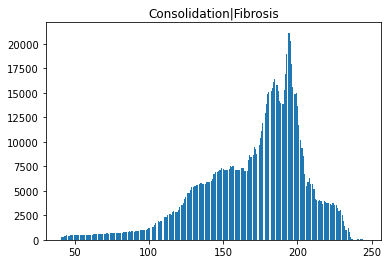

In [32]:
nopneumo = finds[finds['Pneumonia'] != 1]
for i in range(0,50,5):
    path=nopneumo["path"].iloc[i]
    image = io.imread(path)
    image = image[image > 40]
    fig, (ax1) = plt.subplots(1, 1)
    ax1.hist(image.ravel(), bins = 256)
    plt.title(nopneumo["Finding Labels"].iloc[i])
    plt.show()
#Plot the pictures along with the unnormalized histograms for the first few individuals without pneumonia (excluding black pixels)

In [33]:
labs=sample_df['Finding Labels'].tolist()
labsnew=[]
for i in labs:
    elem=i.split('|')
    for j in elem:
        labsnew.append(j)
labsnew=np.unique(labsnew).tolist()

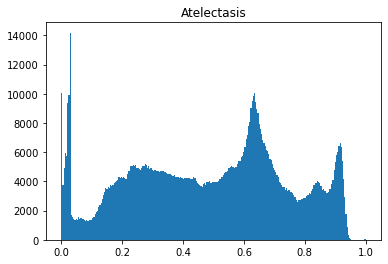

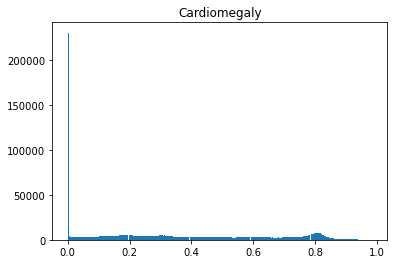

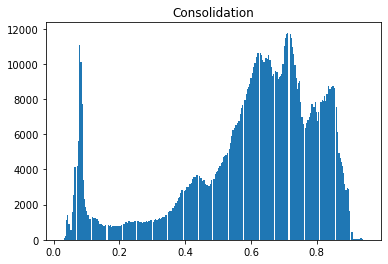

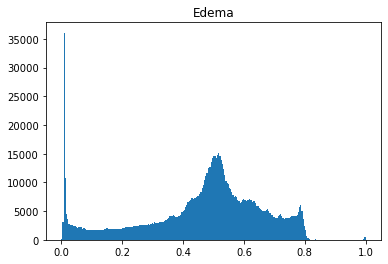

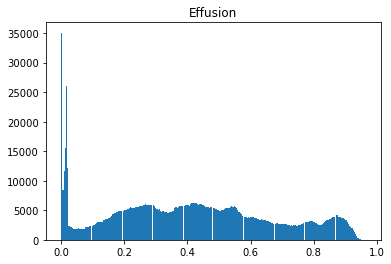

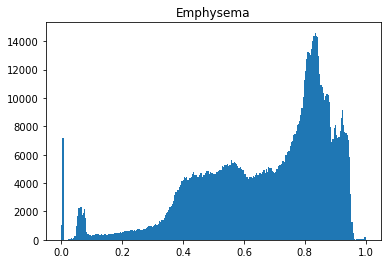

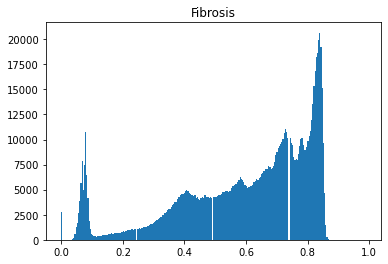

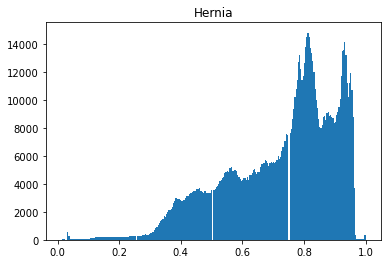

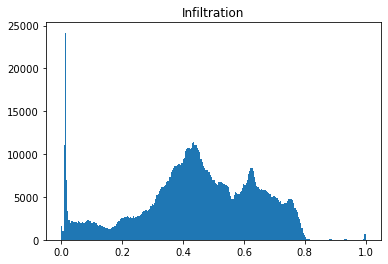

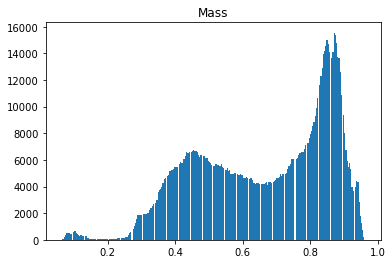

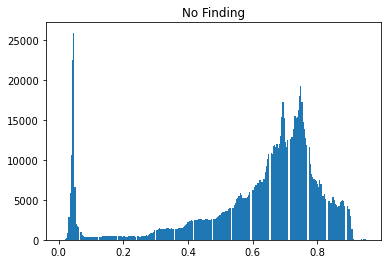

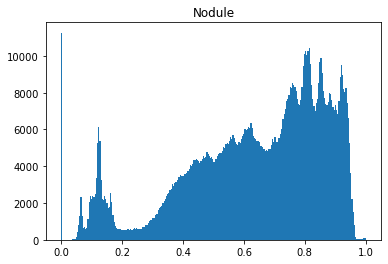

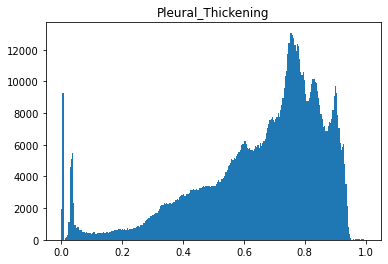

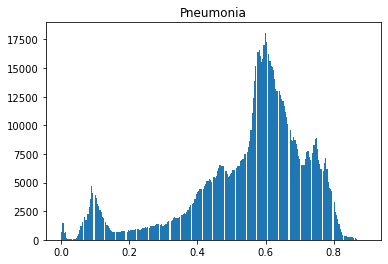

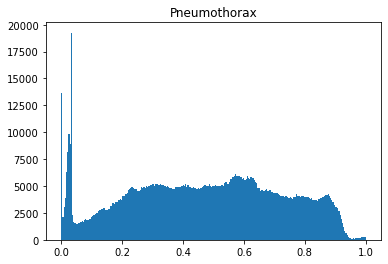

In [34]:
for inde,i in enumerate(labsnew):
    ind=sample_df.loc[sample_df["Finding Labels"]==i].index[0]
    path=sample_df["path"].iloc[ind]
    image = mpimg.imread(path)
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    new_img = image.copy()
    new_img = (new_img - mean_intensity)/std_intensity
    plt.figure()
    plt.hist(image.ravel(),  bins = 256) #range=[-2, 1.5],
    plt.title(i)
#Plot a picture for each disease along with the normalized histogram

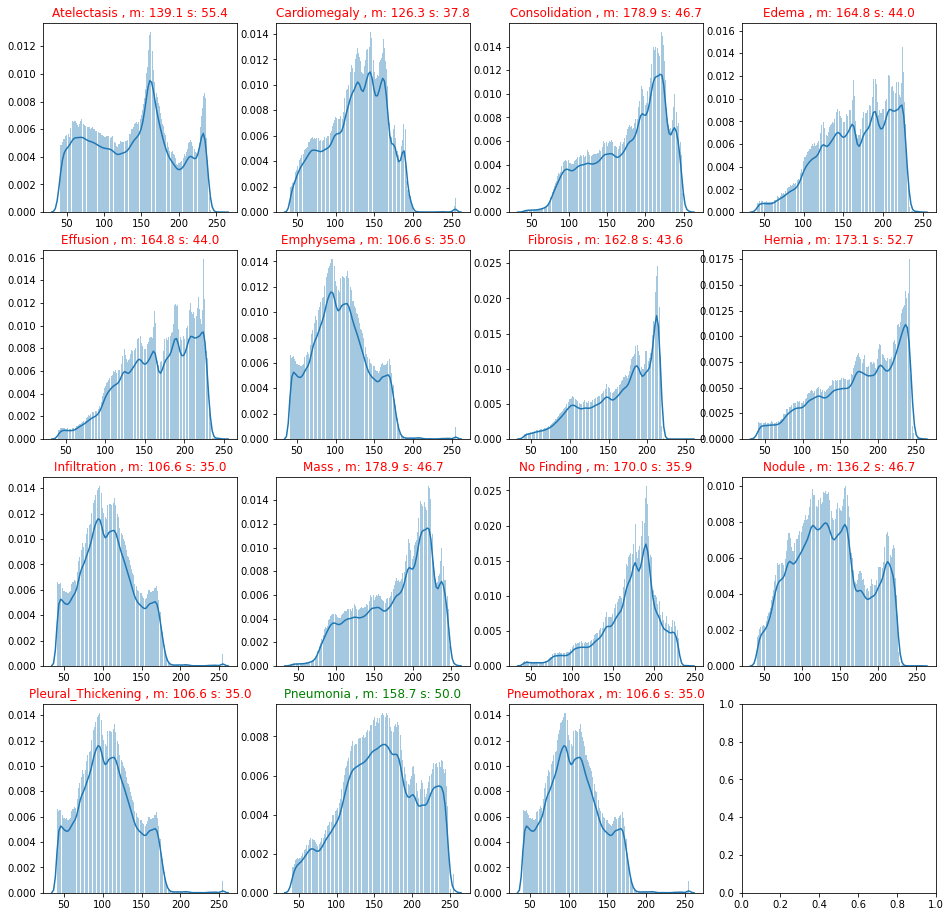

In [45]:
dict1 = []
elem={}
for i in labelsnew:
    elem[i] = sample_df[sample_df[i] == 1]['path'].iloc[0]
dict1.append(elem)    

fig, axes = plt.subplots(4, 4, figsize = (16, 16))
img = io.imread(dict1[0]['Pneumonia'])
img = img[img > 40]
# pneumonia = np.array(img.ravel())
for ax, label, path in zip(axes.flatten(), dict1[0].keys(), dict1[0].values()):
    img2 = io.imread(path)
    img2 = img2[img2 > 40]
    img2 = img2.ravel()
    sns.distplot(img2, ax=ax, bins=256)
    if label == 'Pneumonia':
        ax.set_title(f'{label} , m: {round(img2.mean(),1)} s: {round(img2.std(),1)}', color="green")
    else:
        ax.set_title(f'{label} , m: {round(img2.mean(),1)} s: {round(img2.std(),1)}', color="red")

From the above we can see that pneumonia is similar in terms of distribution shape with nodule. In terms of mean and std it is more similar to Edema, Effusion and Fibrosis.

In [36]:
finish=time.time()
print("Total time to run the script is {}".format(finish-startall))

Total time to run the script is 137.29586505889893
